<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/LLaVa/Fine_tune_LLaVa_on_a_custom_dataset_(with_PyTorch_Lightning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is directly adapted from the tutorial provided here: https://github.com/NielsRogge/Transformers-Tutorials/tree/master/LLaVa




In [ ]:
MAX_LENGTH = 1399
MODEL_ID = "llava-hf/llava-1.5-7b-hf"
REPO_ID = "haquid/LlavaFineTune"
WANDB_PROJECT = "ActionEffect"
WANDB_NAME = "llava-run"

In [ ]:
!pip install datasets transformers accelerate bitsandbytes lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. 

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
import torch
from torch.utils.data import DataLoader
from PIL import Image
from datasets import Dataset
from transformers import BitsAndBytesConfig, pipeline
from transformers import AutoProcessor, LlavaForConditionalGeneration
from IPython.display import display
import re

dataset = load_dataset("sled-umich/Action-Effect", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.78k [00:00<?, ?B/s]

Action-Effect.py:   0%|          | 0.00/5.07k [00:00<?, ?B/s]

action_effect_info.json:   0%|          | 0.00/195k [00:00<?, ?B/s]

action_effect_image_rs.zip:   0%|          | 0.00/408M [00:00<?, ?B/s]

Generating ActionEffect split: 0 examples [00:00, ? examples/s]

In [ ]:
data_as_list = [
    {"image": img, "ground_truth": block["verb noun"]}
    for block in dataset["ActionEffect"]
    for img in block["positive_image_list"]
] + [
    {"image": img, "ground_truth": "no effect"}
    for block in dataset["ActionEffect"]
    for img in block["negative_image_list"]
]

In [ ]:
print(len(data_as_list))
dataset = Dataset.from_list(data_as_list)
dataset = dataset.shuffle(seed=595)

test_dataset = dataset.select(range(2498))
train_dataset = dataset.select(range(2498, 2498 + 1248))
val_dataset = dataset.select(range(2498 + 1248, 4163))

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
})

4163


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 1248
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 2498
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 417
    })
})

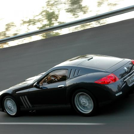

In [ ]:
example = dataset['train'][0]
image = example["image"]
# resize image for smaller displaying
width, height = image.size
image = image.resize((int(0.3*width), int(0.3*height)))
image

In [ ]:
example["ground_truth"]

'no effect'

In [ ]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
processor.tokenizer.padding_side = "right" # during training, one always uses padding on the right

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


In [ ]:
# prompt = "Here is a list of verb noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate potato', 'grind meat', 'hang bag', 'hang shirt', 'ignite paper', 'ignite wood', 'insert key', 'kick door', 'kick football', 'knot rope', 'label bottle', 'label box', 'lock cabinet', 'lock door', 'lock drawer', 'lock window', 'mash potato', 'mix eggs', 'open bottle', 'open box', 'open cabinet', 'open door', 'open drawer', 'open umbrella', 'open window', 'park car', 'peel apple', 'peel banana', 'peel carrot', 'peel orange', 'peel potato', 'pile books', 'pile boxes', 'pile wood', 'pitch baseball', 'ride bicycle', 'rip paper', 'roll paper', 'roll umbrella', 'saw tree', 'saw wood', 'scratch car', 'scratch knee', 'shave hair', 'shut door', 'shut window', 'skin knee', 'slice apple', 'slice meat', 'slice onion', 'slice potato', 'smash door', 'smash window', 'soak shirt', 'soak hair', 'spill coffee', 'split tree', 'split wood', 'squeeze orange', 'squeeze bottle', 'stain paper', 'stain shirt', 'stir coffee', 'stir soup', 'strip tree', 'tear book', 'tear shirt', 'tear paper', 'throw apple', 'throw baseball', 'throw football', 'throw frisbee', 'tie shoe', 'trim hair', 'trim tree', 'twist hair', 'twist rope', 'wrap book', 'wrap box'] \
#                     Your task is to carefully analyze the context, consider plausible actions, and select the most likely verb-noun pair that caused this effect. Follow these steps: 1. Analyze the visual and textual details of the image to understand the effect being depicted. 2. Compare the details with the provided list of verb-noun pairs. 3. Select the single most likely verb-noun pair that caused this effect, based on your reasoning, and output it after the ### sign. If none of the verb-noun pairs would lead to the given image, output no effect instead. You must follow this format. Example 1 Output: Reasoning: The image shows a broken glass on the floor. This suggests an action that involves breaking glass. From the list of verb-noun pairs, 'break glass' is the most plausible cause of this effect. ### break glass \
#                     Example 2 Output: Reasoning: The image shows a single chair by itself. Analyzing the image, there doesn't seem to be any external factors that affected the position of this chair. ### no effect Use these examples to guide your reasoning. Now analyze the provided details and generate your response."

prompt = f"Here is a list of verb-noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate potato', 'grind meat', 'hang bag', 'hang shirt', 'ignite paper', 'ignite wood', 'insert key', 'kick door', 'kick football', 'knot rope', 'label bottle', 'label box', 'lock cabinet', 'lock door', 'lock drawer', 'lock window', 'mash potato', 'mix eggs', 'open bottle', 'open box', 'open cabinet', 'open door', 'open drawer', 'open umbrella', 'open window', 'park car', 'peel apple', 'peel banana', 'peel carrot', 'peel orange', 'peel potato', 'pile books', 'pile boxes', 'pile wood', 'pitch baseball', 'ride bicycle', 'rip paper', 'roll paper', 'roll umbrella', 'saw tree', 'saw wood', 'scratch car', 'scratch knee', 'shave hair', 'shut door', 'shut window', 'skin knee', 'slice apple', 'slice meat', 'slice onion', 'slice potato', 'smash door', 'smash window', 'soak shirt', 'soak hair', 'spill coffee', 'split tree', 'split wood', 'squeeze orange', 'squeeze bottle', 'stain paper', 'stain shirt', 'stir coffee', 'stir soup', 'strip tree', 'tear book', 'tear shirt', 'tear paper', 'throw apple', 'throw baseball', 'throw football', 'throw frisbee', 'tie shoe', 'trim hair', 'trim tree', 'twist hair', 'twist rope', 'wrap book', 'wrap box'] \
            Analyze the image and return just the one verb-noun pair from the provided list that best matches the image. Do not generate any text outside the chosen verb-noun pair. Here are some examples from which you can learn:\n\n\
            Example 1:\nimage: /root/.cache/huggingface/datasets/downloads/extracted/3c8c1e2fb201cd621ad6e3210bedca6e210219600000754e1ab3a757602d3f1f/action_effect_image_rs/bite+apple/positive/img_7.jpeg \nAction: 'bite apple'\n\n\
            Example 2:\nimage: /root/.cache/huggingface/datasets/downloads/extracted/3c8c1e2fb201cd621ad6e3210bedca6e210219600000754e1ab3a757602d3f1f/action_effect_image_rs/crack+glass/positive/img_10.jpeg \nAction: 'crack glass'\n\n\
            Example 3:\nimage: /root/.cache/huggingface/datasets/downloads/extracted/3c8c1e2fb201cd621ad6e3210bedca6e210219600000754e1ab3a757602d3f1f/action_effect_image_rs/break+bowl/negative/img_11.jpeg \nAction: 'no effect'\n\n\
            Example 4:\nimage: /root/.cache/huggingface/datasets/downloads/extracted/3c8c1e2fb201cd621ad6e3210bedca6e210219600000754e1ab3a757602d3f1f/action_effect_image_rs/burn+tree/positive/img_0.jpeg \nAction: 'burn tree'\n\n\
            Example 5:\nimage: /root/.cache/huggingface/datasets/downloads/extracted/3c8c1e2fb201cd621ad6e3210bedca6e210219600000754e1ab3a757602d3f1f/action_effect_image_rs/stir+coffee/positive/img_6.jpg \nAction: 'stir coffee'\n\n\
            Now analyze the image provided and return the best matching verb-noun pair from the provided list. Only return the verb-noun pair and do not generate any text outside the chosen verb-noun pair."

tokens = processor.tokenizer(prompt)

token_length = len(tokens["input_ids"])
print(token_length)

Prompt: Here is a list of verb-noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate

In [ ]:
from transformers import BitsAndBytesConfig, LlavaForConditionalGeneration
import torch

USE_LORA = False
USE_QLORA = True

## Load model

# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning
if USE_QLORA or USE_LORA:
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
        )
    model = LlavaForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        quantization_config=bnb_config,
    )
else:
    # for full fine-tuning, we can speed up the model using Flash Attention
    # only available on certain devices, see https://github.com/Dao-AILab/flash-attention?tab=readme-ov-file#installation-and-features
    model = LlavaForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2",
    )

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [ ]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model


def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = ['multi_modal_projector', 'vision_model']
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=find_all_linear_names(model),
    init_lora_weights="gaussian",
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

In [ ]:
from torch.utils.data import Dataset
from typing import Any, Dict
import random

class LlavaDataset(Dataset):
    """
    PyTorch Dataset for LLaVa. This class takes a HuggingFace Dataset as input.
    """
    def __init__(
        self,
        dataset_name_or_path: Dataset,
        split: str = "train",
    ):
        super().__init__()

        self.split = split

        self.dataset = dataset_name_or_path[self.split]
        self.dataset_length = len(self.dataset)

        print(self.dataset[0])
        self.gt_sequences = [sample["ground_truth"] for sample in self.dataset]

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Dict:
        """
        Returns one item of the dataset.
        """
        sample = self.dataset[idx]

        image = sample["image"]
        target_sequence = self.gt_sequences[idx]

        return image, target_sequence

In [ ]:
train_dataset = LlavaDataset(dataset, split="train")
val_dataset = LlavaDataset(dataset, split="validation")

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=448x448 at 0x7B26092AD810>, 'ground_truth': 'no effect'}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x803 at 0x7B26092AD900>, 'ground_truth': 'open cabinet'}


In [ ]:
train_example = train_dataset[0]
print(train_example)
image, target_sequence = train_example
print(target_sequence)

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=448x448 at 0x7B26092AE8C0>, 'no effect')
no effect


In [ ]:
def train_collate_fn(examples):
    images = []
    texts = []
    for example in examples:
        image, ground_truth = example
        images.append(image)
        # TODO: in the future we can replace this by processor.apply_chat_template
        # conversation = [
        #   {
        #       "role": "user",
        #       "content": [
        #           {"type": "image"},
        #           {"type": "text", "text": "Here is a list of verb noun pairs that could have caused the effect whose final result is shown in the image. ['arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate potato', 'grind meat', 'hang bag', 'hang shirt', 'ignite paper', 'ignite wood', 'insert key', 'kick door', 'kick football', 'knot rope', 'label bottle', 'label box', 'lock cabinet', 'lock door', 'lock drawer', 'lock window', 'mash potato', 'mix eggs', 'open bottle', 'open box', 'open cabinet', 'open door', 'open drawer', 'open umbrella', 'open window', 'park car', 'peel apple', 'peel banana', 'peel carrot', 'peel orange', 'peel potato', 'pile books', 'pile boxes', 'pile wood', 'pitch baseball', 'ride bicycle', 'rip paper', 'roll paper', 'roll umbrella', 'saw tree', 'saw wood', 'scratch car', 'scratch knee', 'shave hair', 'shut door', 'shut window', 'skin knee', 'slice apple', 'slice meat', 'slice onion', 'slice potato', 'smash door', 'smash window', 'soak shirt', 'soak hair', 'spill coffee', 'split tree', 'split wood', 'squeeze orange', 'squeeze bottle', 'stain paper', 'stain shirt', 'stir coffee', 'stir soup', 'strip tree', 'tear book', 'tear shirt', 'tear paper', 'throw apple', 'throw baseball', 'throw football', 'throw frisbee', 'tie shoe', 'trim hair', 'trim tree', 'twist hair', 'twist rope', 'wrap book', 'wrap box'] \
        #           Your task is to carefully analyze the context, consider plausible actions, and select the most likely verb-noun pair that caused this effect. Follow these steps: 1. Analyze the visual and textual details of the image to understand the effect being depicted. 2. Compare the details with the provided list of verb-noun pairs. 3. Select the single most likely verb-noun pair that caused this effect, based on your reasoning, and output it after the ### sign. You must follow this format. Example Output: Reasoning: The image shows a broken glass on the floor. This suggests an action that involves breaking glass. From the list of verb-noun pairs, 'break glass' is the most plausible cause of this effect. ### break glass Now analyze the provided details and generate your response. \nASSISTANT: {ground_truth}"},
        #           ],
        #   }
        # ]
        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Here is a list of verb noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate potato', 'grind meat', 'hang bag', 'hang shirt', 'ignite paper', 'ignite wood', 'insert key', 'kick door', 'kick football', 'knot rope', 'label bottle', 'label box', 'lock cabinet', 'lock door', 'lock drawer', 'lock window', 'mash potato', 'mix eggs', 'open bottle', 'open box', 'open cabinet', 'open door', 'open drawer', 'open umbrella', 'open window', 'park car', 'peel apple', 'peel banana', 'peel carrot', 'peel orange', 'peel potato', 'pile books', 'pile boxes', 'pile wood', 'pitch baseball', 'ride bicycle', 'rip paper', 'roll paper', 'roll umbrella', 'saw tree', 'saw wood', 'scratch car', 'scratch knee', 'shave hair', 'shut door', 'shut window', 'skin knee', 'slice apple', 'slice meat', 'slice onion', 'slice potato', 'smash door', 'smash window', 'soak shirt', 'soak hair', 'spill coffee', 'split tree', 'split wood', 'squeeze orange', 'squeeze bottle', 'stain paper', 'stain shirt', 'stir coffee', 'stir soup', 'strip tree', 'tear book', 'tear shirt', 'tear paper', 'throw apple', 'throw baseball', 'throw football', 'throw frisbee', 'tie shoe', 'trim hair', 'trim tree', 'twist hair', 'twist rope', 'wrap book', 'wrap box'] \
                    Your task is to carefully analyze the context, consider plausible actions, and select the most likely verb-noun pair that caused this effect. Follow these steps: 1. Analyze the visual and textual details of the image to understand the effect being depicted. 2. Compare the details with the provided list of verb-noun pairs. 3. Select the single most likely verb-noun pair that caused this effect, based on your reasoning, and output it after the ### sign. If none of the verb-noun pairs would lead to the given image, output no effect instead. You must follow this format. Example 1 Output: Reasoning: The image shows a broken glass on the floor. This suggests an action that involves breaking glass. From the list of verb-noun pairs, 'break glass' is the most plausible cause of this effect. ### break glass \
                    Example 2 Output: Reasoning: The image shows a single chair by itself. Analyzing the image, there doesn't seem to be any external factors that affected the position of this chair. ### no effect Use these examples to guide your reasoning. Now analyze the provided details and generate your response.\nASSISTANT: {ground_truth}"},
                    ],
            }
        ]
        # conversation = [
        #     {
        #         "role": "user",
        #         "content": [
        #             {"type": "image"},
        #             {"type": "text", "text": f"Here is a list of verb-noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate potato', 'grind meat', 'hang bag', 'hang shirt', 'ignite paper', 'ignite wood', 'insert key', 'kick door', 'kick football', 'knot rope', 'label bottle', 'label box', 'lock cabinet', 'lock door', 'lock drawer', 'lock window', 'mash potato', 'mix eggs', 'open bottle', 'open box', 'open cabinet', 'open door', 'open drawer', 'open umbrella', 'open window', 'park car', 'peel apple', 'peel banana', 'peel carrot', 'peel orange', 'peel potato', 'pile books', 'pile boxes', 'pile wood', 'pitch baseball', 'ride bicycle', 'rip paper', 'roll paper', 'roll umbrella', 'saw tree', 'saw wood', 'scratch car', 'scratch knee', 'shave hair', 'shut door', 'shut window', 'skin knee', 'slice apple', 'slice meat', 'slice onion', 'slice potato', 'smash door', 'smash window', 'soak shirt', 'soak hair', 'spill coffee', 'split tree', 'split wood', 'squeeze orange', 'squeeze bottle', 'stain paper', 'stain shirt', 'stir coffee', 'stir soup', 'strip tree', 'tear book', 'tear shirt', 'tear paper', 'throw apple', 'throw baseball', 'throw football', 'throw frisbee', 'tie shoe', 'trim hair', 'trim tree', 'twist hair', 'twist rope', 'wrap book', 'wrap box'] \
        #             Analyze the image and return just the one verb-noun pair from the provided list that best matches the image. Do not generate any text outside the chosen verb-noun pair. Here are some examples from which you can learn:\n\n\
        #             Example 1:\nimage: /root/.cache/huggingface/datasets/downloads/extracted/3c8c1e2fb201cd621ad6e3210bedca6e210219600000754e1ab3a757602d3f1f/action_effect_image_rs/bite+apple/positive/img_7.jpeg \nAction: 'bite apple'\n\n\
        #             Example 2:\nimage: /root/.cache/huggingface/datasets/downloads/extracted/3c8c1e2fb201cd621ad6e3210bedca6e210219600000754e1ab3a757602d3f1f/action_effect_image_rs/crack+glass/positive/img_10.jpeg \nAction: 'crack glass'\n\n\
        #             Example 3:\nimage: /root/.cache/huggingface/datasets/downloads/extracted/3c8c1e2fb201cd621ad6e3210bedca6e210219600000754e1ab3a757602d3f1f/action_effect_image_rs/break+bowl/negative/img_11.jpeg \nAction: 'no effect'\n\n\
        #             Example 4:\nimage: /root/.cache/huggingface/datasets/downloads/extracted/3c8c1e2fb201cd621ad6e3210bedca6e210219600000754e1ab3a757602d3f1f/action_effect_image_rs/burn+tree/positive/img_0.jpeg \nAction: 'burn tree'\n\n\
        #             Example 5:\nimage: /root/.cache/huggingface/datasets/downloads/extracted/3c8c1e2fb201cd621ad6e3210bedca6e210219600000754e1ab3a757602d3f1f/action_effect_image_rs/stir+coffee/positive/img_6.jpg \nAction: 'stir coffee'\n\n\
        #             Now analyze the image provided and return the best matching verb-noun pair from the provided list. Only return the verb-noun pair and do not generate any text outside the chosen verb-noun pair.\nASSISTANT: {ground_truth}"},
        #         ],
        #     }
        # ]
        prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
        texts.append(prompt)

    batch = processor(text=texts, images=images, padding=True, truncation=True, max_length=1100, return_tensors="pt")

    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = labels

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]
    labels = batch["labels"]

    return input_ids, attention_mask, pixel_values, labels


def eval_collate_fn(examples):
    # we only feed the prompt to the model
    images = []
    texts = []
    answers = []
    for example in examples:
        image, ground_truth = example
        images.append(image)
        # TODO: in the future we can replace this by processor.apply_chat_template
        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Here is a list of verb noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate potato', 'grind meat', 'hang bag', 'hang shirt', 'ignite paper', 'ignite wood', 'insert key', 'kick door', 'kick football', 'knot rope', 'label bottle', 'label box', 'lock cabinet', 'lock door', 'lock drawer', 'lock window', 'mash potato', 'mix eggs', 'open bottle', 'open box', 'open cabinet', 'open door', 'open drawer', 'open umbrella', 'open window', 'park car', 'peel apple', 'peel banana', 'peel carrot', 'peel orange', 'peel potato', 'pile books', 'pile boxes', 'pile wood', 'pitch baseball', 'ride bicycle', 'rip paper', 'roll paper', 'roll umbrella', 'saw tree', 'saw wood', 'scratch car', 'scratch knee', 'shave hair', 'shut door', 'shut window', 'skin knee', 'slice apple', 'slice meat', 'slice onion', 'slice potato', 'smash door', 'smash window', 'soak shirt', 'soak hair', 'spill coffee', 'split tree', 'split wood', 'squeeze orange', 'squeeze bottle', 'stain paper', 'stain shirt', 'stir coffee', 'stir soup', 'strip tree', 'tear book', 'tear shirt', 'tear paper', 'throw apple', 'throw baseball', 'throw football', 'throw frisbee', 'tie shoe', 'trim hair', 'trim tree', 'twist hair', 'twist rope', 'wrap book', 'wrap box'] \
                    Your task is to carefully analyze the context, consider plausible actions, and select the most likely verb-noun pair that caused this effect. Follow these steps: 1. Analyze the visual and textual details of the image to understand the effect being depicted. 2. Compare the details with the provided list of verb-noun pairs. 3. Select the single most likely verb-noun pair that caused this effect, based on your reasoning, and output it after the ### sign. If none of the verb-noun pairs would lead to the given image, output no effect instead. You must follow this format. Example 1 Output: Reasoning: The image shows a broken glass on the floor. This suggests an action that involves breaking glass. From the list of verb-noun pairs, 'break glass' is the most plausible cause of this effect. ### break glass \
                    Example 2 Output: Reasoning: The image shows a single chair by itself. Analyzing the image, there doesn't seem to be any external factors that affected the position of this chair. ### no effect Use these examples to guide your reasoning. Now analyze the provided details and generate your response.\nASSISTANT:"},
                    ],
            }
        ]
        # conversation = [
        #     {
        #         "role": "user",
        #         "content": [
        #             {"type": "image"},
        #             {"type": "text", "text": f"Here is a list of verb-noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate potato', 'grind meat', 'hang bag', 'hang shirt', 'ignite paper', 'ignite wood', 'insert key', 'kick door', 'kick football', 'knot rope', 'label bottle', 'label box', 'lock cabinet', 'lock door', 'lock drawer', 'lock window', 'mash potato', 'mix eggs', 'open bottle', 'open box', 'open cabinet', 'open door', 'open drawer', 'open umbrella', 'open window', 'park car', 'peel apple', 'peel banana', 'peel carrot', 'peel orange', 'peel potato', 'pile books', 'pile boxes', 'pile wood', 'pitch baseball', 'ride bicycle', 'rip paper', 'roll paper', 'roll umbrella', 'saw tree', 'saw wood', 'scratch car', 'scratch knee', 'shave hair', 'shut door', 'shut window', 'skin knee', 'slice apple', 'slice meat', 'slice onion', 'slice potato', 'smash door', 'smash window', 'soak shirt', 'soak hair', 'spill coffee', 'split tree', 'split wood', 'squeeze orange', 'squeeze bottle', 'stain paper', 'stain shirt', 'stir coffee', 'stir soup', 'strip tree', 'tear book', 'tear shirt', 'tear paper', 'throw apple', 'throw baseball', 'throw football', 'throw frisbee', 'tie shoe', 'trim hair', 'trim tree', 'twist hair', 'twist rope', 'wrap book', 'wrap box'] \
        #             Analyze the image and return just the one verb-noun pair from the provided list that best matches the image. Do not generate any text outside the chosen verb-noun pair. Here are some examples from which you can learn:\n\n\
        #             Example 1:\nimage: /root/.cache/huggingface/datasets/downloads/extracted/3c8c1e2fb201cd621ad6e3210bedca6e210219600000754e1ab3a757602d3f1f/action_effect_image_rs/bite+apple/positive/img_7.jpeg \nAction: 'bite apple'\n\n\
        #             Example 2:\nimage: /root/.cache/huggingface/datasets/downloads/extracted/3c8c1e2fb201cd621ad6e3210bedca6e210219600000754e1ab3a757602d3f1f/action_effect_image_rs/crack+glass/positive/img_10.jpeg \nAction: 'crack glass'\n\n\
        #             Example 3:\nimage: /root/.cache/huggingface/datasets/downloads/extracted/3c8c1e2fb201cd621ad6e3210bedca6e210219600000754e1ab3a757602d3f1f/action_effect_image_rs/break+bowl/negative/img_11.jpeg \nAction: 'no effect'\n\n\
        #             Example 4:\nimage: /root/.cache/huggingface/datasets/downloads/extracted/3c8c1e2fb201cd621ad6e3210bedca6e210219600000754e1ab3a757602d3f1f/action_effect_image_rs/burn+tree/positive/img_0.jpeg \nAction: 'burn tree'\n\n\
        #             Example 5:\nimage: /root/.cache/huggingface/datasets/downloads/extracted/3c8c1e2fb201cd621ad6e3210bedca6e210219600000754e1ab3a757602d3f1f/action_effect_image_rs/stir+coffee/positive/img_6.jpg \nAction: 'stir coffee'\n\n\
        #             Now analyze the image provided and return the best matching verb-noun pair from the provided list. Only return the verb-noun pair and do not generate any text outside the chosen verb-noun pair.\nASSISTANT: "},
        #         ],
        #     }
        # ]
        prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
        texts.append(prompt)
        answers.append(ground_truth)

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]

    return input_ids, attention_mask, pixel_values, answers

In [ ]:
import lightning as L
from torch.utils.data import DataLoader
import re
from nltk import edit_distance
import numpy as np


class LlavaModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

        self.batch_size = config.get("batch_size")

    def training_step(self, batch, batch_idx):

        input_ids, attention_mask, pixel_values, labels = batch

        outputs = self.model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                pixel_values=pixel_values,
                                labels=labels)
        loss = outputs.loss

        #self.log("train_loss", loss)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        print(f"{batch_idx}, loss: {loss.item()}")

        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        input_ids, attention_mask, pixel_values, answers = batch

        # autoregressively generate token IDs
        generated_ids = self.model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                       pixel_values=pixel_values, max_new_tokens=500)
        # turn them back into text, chopping of the prompt
        # important: we don't skip special tokens here, because we want to see them in the output
        predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)

        scores = []
        for pred, answer in zip(predictions, answers):
            print(pred)
            matcha = re.search(r"###\s*(.*)", pred)
            pred1 = "NONE"
            if matcha:
                pred1 = matcha.group(1).strip().lower()
            pred = pred1
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))

        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(val_dataset, collate_fn=eval_collate_fn, batch_size=self.batch_size, shuffle=False, num_workers=4)

In [ ]:
config = {"max_epochs": 1,
          # "val_check_interval": 0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 1e-4,
          "batch_size": 2,
          "num_nodes": 1,
          "warmup_steps": 50,
          "result_path": "./result",
          "verbose": True,
}

model_module = LlavaModelPLModule(config, processor, model)

In [ ]:
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from huggingface_hub import HfApi

api = HfApi()

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub(REPO_ID,
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub(REPO_ID,
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub(REPO_ID,
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")

In [ ]:
# import torch, gc
# import os
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# torch.save(model_module.state_dict(), "model_weights.pth")

In [ ]:
# import wandb
# wandb.finish()

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project=WANDB_PROJECT, name=WANDB_NAME)

trainer = L.Trainer(
        accelerator="gpu",
        devices=[0],
        max_epochs=config.get("max_epochs"),
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="16-mixed",
        limit_val_batches=5,
        num_sanity_val_steps=0,
        logger=wandb_logger,
        callbacks=[PushToHubCallback(), early_stop_callback],
)

trainer.fit(model_module)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cor

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PeftModel | 3.7 B  | train
--------------------------------------------
21.2 M    Trainable params
3.7 B     Non-trainable params
3.7 B     Total params
14,740.447Total estimated model params size (MB)
2962      Modules in train mode
757       Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PeftModel | 3.7 B  | train
--------------------------------------------
21.2 M    Trainable params
3.7 B     Non-trainable params
3.7 B     Total params
14,740.447Total estimated model params size (MB)
2962      Modules in train mode
757       Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

0, loss: 8.968781471252441
1, loss: 8.654886245727539
2, loss: 8.612984657287598
3, loss: 8.65068244934082
4, loss: 8.731918334960938
5, loss: 8.335149765014648
6, loss: 8.678475379943848
7, loss: 8.639670372009277
8, loss: 7.031810760498047
9, loss: 7.252579212188721
10, loss: 6.9295735359191895
11, loss: 6.882903575897217
12, loss: 7.1249613761901855
13, loss: 7.299172401428223
14, loss: 7.300252437591553
15, loss: 7.040361404418945
16, loss: 5.941196441650391
17, loss: 6.157665729522705
18, loss: 6.102280139923096
19, loss: 5.987213611602783
20, loss: 5.927029609680176
21, loss: 6.1716179847717285
22, loss: 5.879151344299316
23, loss: 6.106337070465088
24, loss: 5.118027210235596
25, loss: 5.04262638092041
26, loss: 5.3781418800354
27, loss: 5.136420726776123
28, loss: 5.066173076629639
29, loss: 5.0172576904296875
30, loss: 5.142781734466553
31, loss: 5.249917030334473
32, loss: 4.607573509216309
33, loss: 4.352842330932617
34, loss: 4.358339309692383
35, loss: 4.453515529632568
36

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


196, loss: 2.2055535316467285
197, loss: 2.2055296897888184
198, loss: 2.202425956726074
199, loss: 2.204446315765381
200, loss: 2.197924852371216
201, loss: 2.1988120079040527
202, loss: 2.1947224140167236
203, loss: 2.1967711448669434
204, loss: 2.196715831756592
205, loss: 2.200287103652954
206, loss: 2.1977059841156006
207, loss: 2.198566436767578
208, loss: 2.1910400390625
209, loss: 2.191516876220703
210, loss: 2.193329095840454
211, loss: 2.191358804702759
212, loss: 2.1880829334259033
213, loss: 2.191861629486084
214, loss: 2.19647216796875
215, loss: 2.188821792602539
216, loss: 2.186520576477051
217, loss: 2.186943769454956
218, loss: 2.1847236156463623
219, loss: 2.183501720428467
220, loss: 2.1892502307891846
221, loss: 2.1890318393707275
222, loss: 2.1829638481140137
223, loss: 2.188255786895752
224, loss: 2.1803693771362305
225, loss: 2.177382469177246
226, loss: 2.1782338619232178
227, loss: 2.179985523223877
228, loss: 2.180891513824463
229, loss: 2.182614326477051
230,

Validation: |          | 0/? [00:00<?, ?it/s]

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


Reasoning: The image shows a person standing on a ladder, with a book located on a higher step. This suggests an action that involves climbing a ladder with a book in hand. From the list of verb-noun pairs, 'climb ladder with book' is the most plausible cause of this effect.
Prediction: NONE
    Answer: open cabinet
 Normed: 1.0
Reasoning: The image shows a person standing on a ladder, with a book located on a different part of the scene. This suggests an action that involves climbing a ladder and carrying a book. From the list of verb-noun pairs, 'carry book' is the most plausible cause of this effect.


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Reasoning: The image shows a person standing in a room with a couch and a table. It is plausible that the person arranged the couch and the table in the room. From the list of verb-noun pairs, 'arrange couch and table' is the most likely cause of this effect. ### arrange couch and table
Prediction: arrange couch and table
    Answer: tear book
 Normed: 0.8695652173913043
Reasoning: The image shows a person standing on a ladder, with a book located on a different part of the scene. This suggests an action that involves climbing a ladder and carrying a book. From the list of verb-noun pairs, 'carry book' is the most plausible cause of this effect.
Reasoning: The image shows a person standing in a room with a couch and a table. This suggests an action that involves entering a room. From the list of verb-noun pairs, 'enter room' is the most plausible cause of this effect. ### enter room
Prediction: enter room
    Answer: tear book
 Normed: 0.5
Reasoning: The image shows a person standing o

adapter_model.safetensors:   0%|          | 0.00/84.8M [00:00<?, ?B/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Pushing model to the hub after training


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


In [ ]:
from transformers import AutoProcessor, BitsAndBytesConfig, LlavaForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained(MODEL_ID)

# Define quantization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
)
# Load the base model with adapters on top
model = LlavaForConditionalGeneration.from_pretrained(
    REPO_ID,
    torch_dtype=torch.float16,
    quantization_config=quantization_config,
)

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


adapter_config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/84.8M [00:00<?, ?B/s]

0
USER:  
Here is a list of verb noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'gra

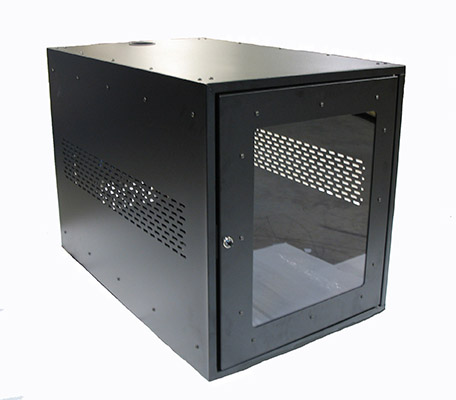

USER:  
Here is a list of verb noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate

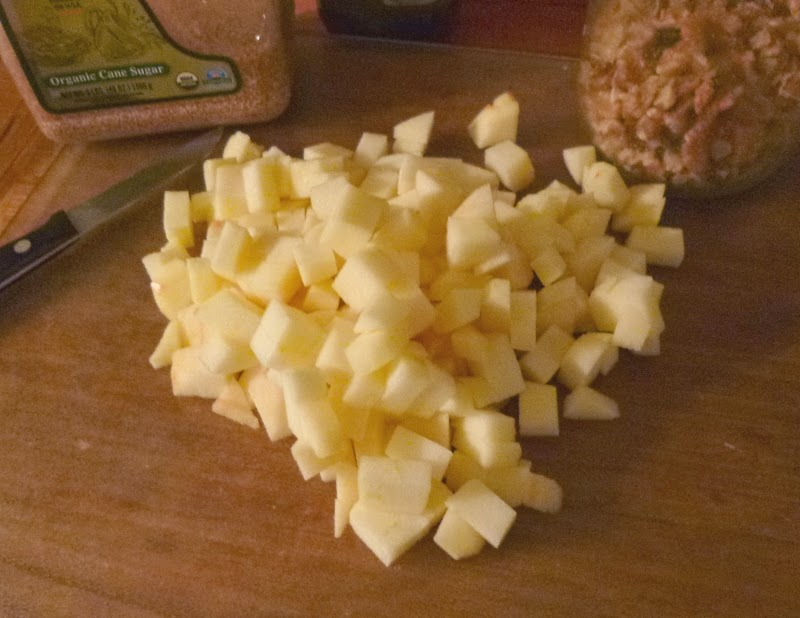

USER:  
Here is a list of verb noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate

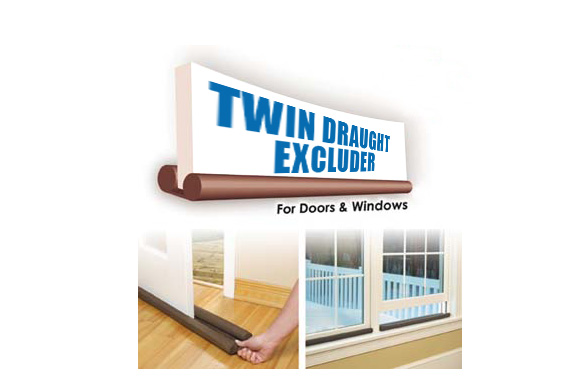

USER:  
Here is a list of verb noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate

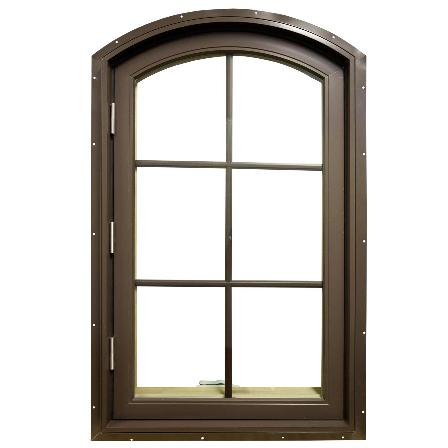

USER:  
Here is a list of verb noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate

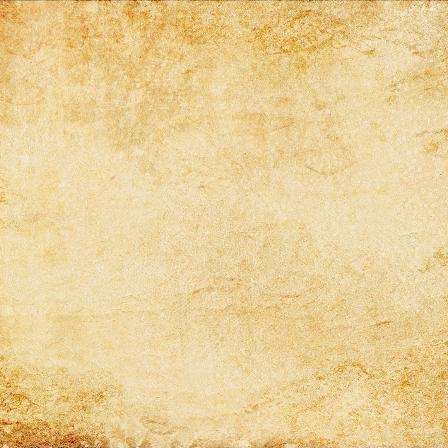

USER:  
Here is a list of verb noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate

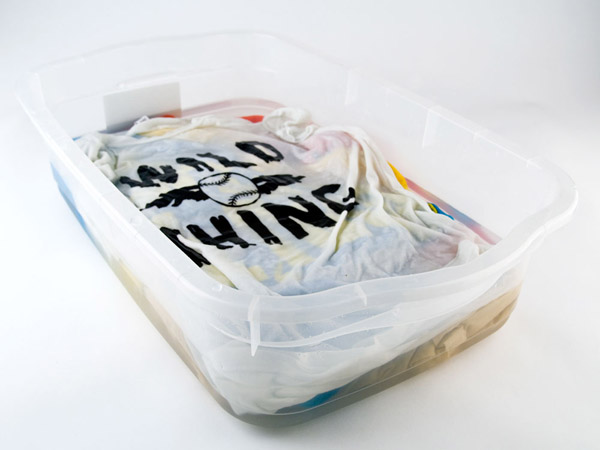

USER:  
Here is a list of verb noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate

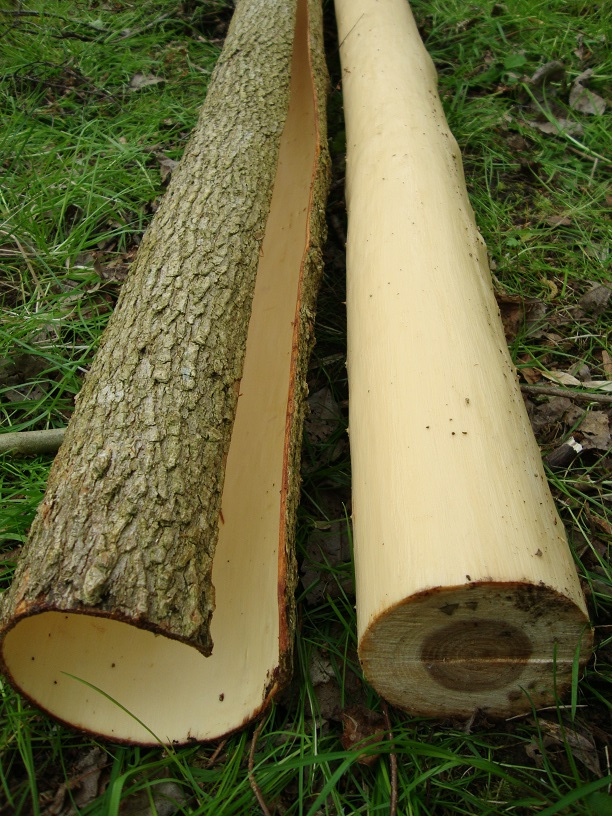

USER:  
Here is a list of verb noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate

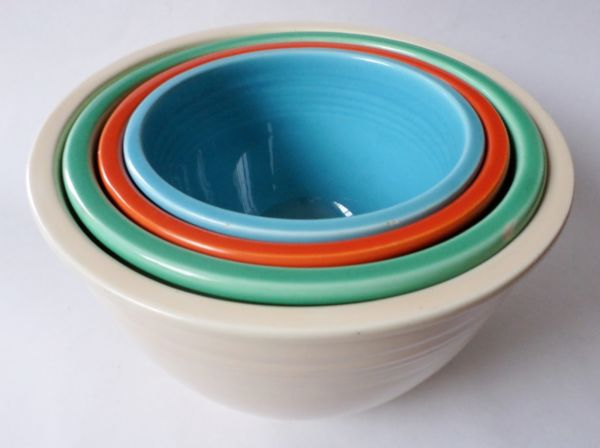

USER:  
Here is a list of verb noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate

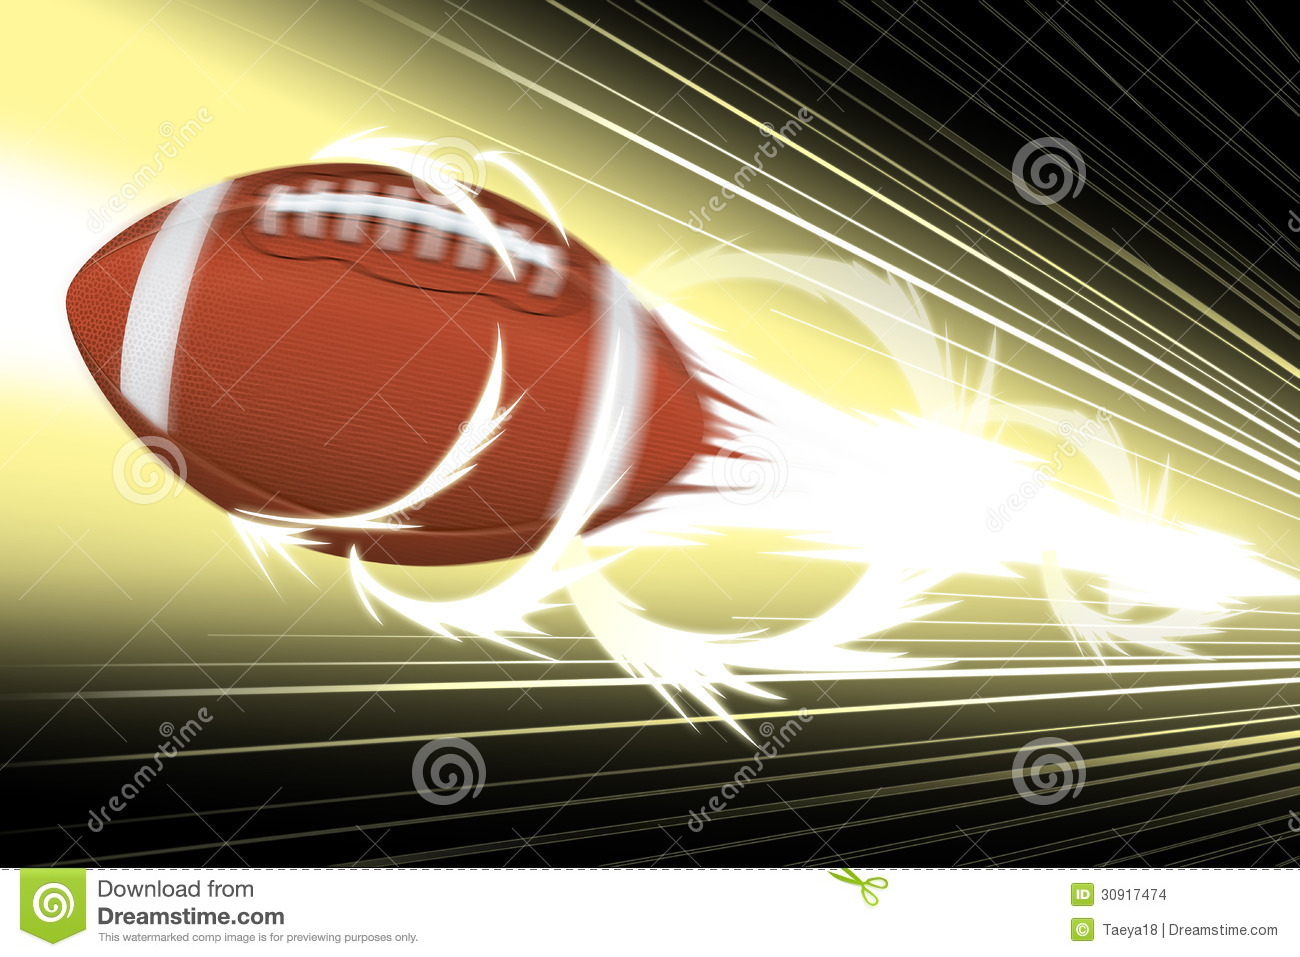

USER:  
Here is a list of verb noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate

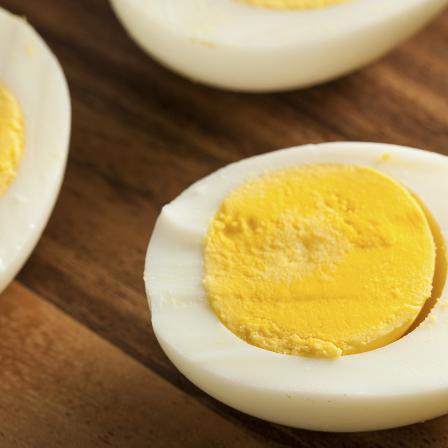

10


KeyboardInterrupt: 

In [ ]:
conversation1 = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Here is a list of verb noun pairs that could have caused the effect whose final result is shown in the image. ['no effect', 'arrange chairs', 'arrange flowers', 'bake potato', 'beat eggs', 'bend knee', 'bend tree', 'bind hair', 'bite apple', 'block door', 'block window', 'boil egg', 'boil potato', 'break bowl', 'break cup', 'break door', 'break egg', 'break glass', 'break window', 'burn book', 'burn paper', 'burn tree', 'burn wood', 'burst balloon', 'burst door', 'carry bag', 'carry book', 'carry umbrella', 'chop carrot', 'chop meat', 'chop onion', 'chop tree', 'chop wood', 'close book', 'close cabinet', 'close door', 'close drawer', 'close window', 'coil rope', 'cook egg', 'cook meat', 'cook onion', 'cook potato', 'crack bottle', 'crack egg', 'crack glass', 'crack window', 'crash car', 'crop hair', 'cut apple', 'cut meat', 'cut onion', 'cut potato', 'cut tree', 'cut wood', 'fasten door', 'fasten window', 'fold paper', 'fry egg', 'fry meat', 'fry potato', 'grate carrot', 'grate potato', 'grind meat', 'hang bag', 'hang shirt', 'ignite paper', 'ignite wood', 'insert key', 'kick door', 'kick football', 'knot rope', 'label bottle', 'label box', 'lock cabinet', 'lock door', 'lock drawer', 'lock window', 'mash potato', 'mix eggs', 'open bottle', 'open box', 'open cabinet', 'open door', 'open drawer', 'open umbrella', 'open window', 'park car', 'peel apple', 'peel banana', 'peel carrot', 'peel orange', 'peel potato', 'pile books', 'pile boxes', 'pile wood', 'pitch baseball', 'ride bicycle', 'rip paper', 'roll paper', 'roll umbrella', 'saw tree', 'saw wood', 'scratch car', 'scratch knee', 'shave hair', 'shut door', 'shut window', 'skin knee', 'slice apple', 'slice meat', 'slice onion', 'slice potato', 'smash door', 'smash window', 'soak shirt', 'soak hair', 'spill coffee', 'split tree', 'split wood', 'squeeze orange', 'squeeze bottle', 'stain paper', 'stain shirt', 'stir coffee', 'stir soup', 'strip tree', 'tear book', 'tear shirt', 'tear paper', 'throw apple', 'throw baseball', 'throw football', 'throw frisbee', 'tie shoe', 'trim hair', 'trim tree', 'twist hair', 'twist rope', 'wrap book', 'wrap box'] \
                    Your task is to carefully analyze the context, consider plausible actions, and select the most likely verb-noun pair that caused this effect. Follow these steps: 1. Analyze the visual and textual details of the image to understand the effect being depicted. 2. Compare the details with the provided list of verb-noun pairs. 3. Select the single most likely verb-noun pair that caused this effect, based on your reasoning, and output it after the ### sign. If none of the verb-noun pairs would lead to the given image, output no effect instead. You must follow this format. Example 1 Output: Reasoning: The image shows a broken glass on the floor. This suggests an action that involves breaking glass. From the list of verb-noun pairs, 'break glass' is the most plausible cause of this effect. ### break glass \
                    Example 2 Output: Reasoning: The image shows a single chair by itself. Analyzing the image, there doesn't seem to be any external factors that affected the position of this chair. ### no effect Use these examples to guide your reasoning. Now analyze the provided details and generate your response."},
                    ],
            }
        ]
batch_size = 10
preds = []

for idx in range(0, len(dataset['test']), batch_size):
    print(idx)
    batch_images = dataset['test'][idx:idx + batch_size]['image']

    prompts = []
    for _ in batch_images:
        prompt = processor.apply_chat_template(conversation1, add_generation_prompt=True)
        prompts.append(prompt)

    inputs = processor(
        images=batch_images,
        text=prompts,
        padding=True,
        return_tensors="pt",
    ).to(model.device, torch.float16)

    generate_ids = model.generate(**inputs, max_new_tokens=500)
    answers = processor.batch_decode(generate_ids, skip_special_tokens=True)
    idx = 0
    for answer in answers:
        print(answer)
        print()
        display(batch_images[idx])
        idx += 1
        trimmed = answer.split("ASSISTANT:", 1)[-1].strip()
        #print("ANSWER", trimmed)
        match = re.search(r"###\s*(.*)", trimmed)
        if match:
            preds.append(match.group(1).strip().lower())
        else:
            preds.append("None")

In [ ]:
#code taken from EECS 595 hw4
def evaluate_predictions(predictions, ground_truth):
    """
    Calculate accuracy of predictions.

    Args:
        predictions (list): Model predictions
        ground_truth (list): Correct answers

    Returns:
        float: Accuracy score
    """
    formatted_predictions = [
    p[0].strip("'").casefold() if isinstance(p, list) else p.strip("'").casefold()
    for p in predictions
    ]
    #print(formatted_predictions)
    correct = sum(1 for p, g in zip(formatted_predictions, ground_truth) if p.strip("'").casefold() == g.casefold())
    print(correct, " ", len(ground_truth))
    return correct / len(predictions) if predictions else 0

In [ ]:
acc = evaluate_predictions(preds, dataset['test']['ground_truth'][:10])
print(acc)
print(preds)
print(dataset['test'][:10]['ground_truth'])

0   10
0.0
['None', 'bring book up ladder', 'climb ladder with book', 'None', 'None', 'None', 'climb ladder and carry book', 'None', 'bring book up ladder', 'stand in room']
['no effect', 'cut apple', 'no effect', 'close window', 'no effect', 'soak shirt', 'strip tree', 'no effect', 'throw football', 'boil egg']


In [ ]:
print(preds)

['None', 'bring book up ladder', 'climb ladder with book', 'None', 'None', 'None', 'climb ladder and carry book', 'None', 'bring book up ladder', 'stand in room']
